In [1]:
# Jupyer Notebook Theme: jt -t monokai -f fira -fs 10 -nf ptsans -nfs 11 -N -kl -cursw 2 -cursc r -cellw 95% -T
# Check python version
import sys
cdPyVer = 0x600
cdSysVer = sys.version[:5]
print("%s%s" %("My python version is: ", cdSysVer)) # strangely it works only on 3.7.4 and not 3.7.6

# Import libraries
import pandas as pd 
import numpy as np
import warnings

# Progress Bar
from tqdm.auto import tqdm

# Visualisation Libraries
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.gridspec import GridSpec
plt.style.use('seaborn-dark') # use this theme as you are using dark theme in the notebook
import seaborn as sns
import folium
from folium.plugins import HeatMap, FastMarkerCluster

# Utility Modules
sys.path.append('/Users/Shandeep/data_science/delivery_hero')


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
              
warnings.filterwarnings('ignore')

My python version is: 3.9.1


/opt/homebrew/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/zd/56rcpp8570x7kl33_cx2840c0000gn/T/ipykernel_25884/3664975895.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark') # use this theme as you are using dark theme in the notebook


In [2]:

df = pd.read_csv('/Users/shandeep/data_science/other_projects/datasets/bolt/test.csv') 
desc = pd.read_csv('/Users/shandeep/data_science/other_projects/datasets/bolt/description.csv') 
df.head()

,order_id_new,order_try_id_new,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,entered_by,b_state,dest_change_number,prediction_price_type,predicted_distance,predicted_duration,change_reason_pricing,ticket_id_new,device_token,rider_app_version,order_state,order_try_state,driver_app_version,driver_device_uid_new,device_name,eu_indicator,overpaid_ride_ticket,fraud_score
0,22,22,2020-02-02 3:37:31,4.04,10.0,2839,700,1,client,finished,1,upfront,13384.0,1091.0,NaN,1376,NaN,CI.4.17,finished,finished,DA.4.37,1596,Xiaomi Redmi 6,1,0,-1383.0
1,618,618,2020-02-08 2:26:19,6.09,3.6,5698,493,1,client,finished,1,upfront,2286.0,360.0,NaN,2035,NaN,CA.5.43,finished,finished,DA.4.39,1578,Samsung SM-G965F,1,0,NaN
2,657,657,2020-02-08 11:50:35,4.32,3.5,4426,695,1,client,finished,1,upfront,4101.0,433.0,NaN,2222,NaN,CA.5.43,finished,finished,DA.4.37,951,Samsung SM-A530F,1,0,-166.0
3,313,313,2020-02-05 6:34:54,72871.72,NaN,49748,1400,0,client,finished,2,upfront_destination_changed,3017.0,600.0,client_destination_changed,1788,NaN,CA.5.23,finished,finished,DA.4.37,1587,TECNO-Y6,0,1,NaN
4,1176,1176,2020-02-13 17:31:24,20032.50,19500.0,10273,5067,1,client,finished,1,upfront,14236.0,2778.0,NaN,2710,NaN,CA.5.04,finished,finished,DA.4.37,433,Itel W5504,0,0,NaN


In [3]:
df.shape

(4943, 26)

In [4]:
desc_string = desc.to_markdown(index=False)

In [5]:
desc_string

'| variable                           | description                                                                                                                                                                                    |\n|:-----------------------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|\n| order_id_new                       | ID of an order                                                                                                                                                                                 |\n| order_try_id_new                   | ID of an order “attempt” (one order can be attempted on multiple drivers, until one accepts)                                                                                                   |\n| Metered_price, distance & duration | Actual price, distance and d

### Problem Statement
You want to improve the precision of upfront pricing, which is currently based on predicted distance and time. When the difference between the upfront price and the metered price exceeds 20%, the pricing switches to the metered price.

### Approach
Given the problem statement and the data at hand, the main task here is to create a predictive model that can accurately estimate the upfront price (i.e., reducing the error rate to less than 20%).

In [6]:
"""Define a function that gives me detailed dataframe information"""

def df_info(df, nunique=True, mem_usage=True) -> pd.DataFrame:
    "show general info about df, more detailed than df.info()"
    info_details = pd.DataFrame(index=df.columns)

    info_details['dtype']    = df.dtypes
    if mem_usage: info_details['memory_mb'] = np.round(df.memory_usage(deep=True ) /1_000_000, 2)

    if nunique: info_details['nunique']  = df.nunique()

    info_details['notnull']  = df.notnull().sum()
    info_details['isnull']   = df.isnull().sum()
    info_details['isnull_%'] = np.round(df.isnull().sum( ) *100 / len(df), 2)

    # Compute min and max occurrence counts for object columns
    object_cols = df.select_dtypes(include=['object']).columns
    for col in object_cols:
        counts = df[col].value_counts()
        info_details.loc[col, 'min_count'] = counts.min()
        info_details.loc[col, 'max_count'] = counts.max()

    return info_details.reset_index(drop=False).rename(columns={'index' :'column'})

In [7]:
pwd

'/Users/shandeep/data_science/other_projects/bolt'

In [8]:
from utils import utils, viz_utils, pandas_utils
df_info(df)

,column,dtype,memory_mb,nunique,notnull,isnull,isnull_%,min_count,max_count
0,order_id_new,int64,0.04,4166,4943,0,0.00,NaN,NaN
1,order_try_id_new,int64,0.04,4166,4943,0,0.00,NaN,NaN
2,calc_created,object,0.37,4165,4943,0,0.00,1.0,6.0
3,metered_price,float64,0.04,2395,4923,20,0.40,NaN,NaN
4,upfront_price,float64,0.04,289,3409,1534,31.03,NaN,NaN
5,distance,int64,0.04,3661,4943,0,0.00,NaN,NaN
6,duration,int64,0.04,2308,4943,0,0.00,NaN,NaN
7,gps_confidence,int64,0.04,2,4943,0,0.00,NaN,NaN
8,entered_by,object,0.31,3,4943,0,0.00,5.0,4722.0
9,b_state,object,0.32,1,4943,0,0.00,4943.0,4943.0


In [9]:
# Check for duplicate rows
duplicate_rows = df.duplicated()

# Print the duplicate rows
duplicate_rows

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
30      False
31      False
32      False
33      False
34      False
35      False
36      False
37      False
38      False
39      False
40      False
41      False
42      False
43      False
44      False
45      False
46      False
47      False
48      False
49      False
50      False
51      False
52      False
53      False
54      False
55      False
56      False
57      False
58      False
59      False
60      False
61      False
62      False
63      False
64      False
65      False
66      False
67      False
68      False
69      False
70      False
71    

##### Numerical Columns

In [10]:
# Column Types

# Columns with numerical data
numerical_columns = df._get_numeric_data().columns

# Number of numerical columns
print('Number of columns with numerical data: ', len(numerical_columns))

# visualize data frame
df[numerical_columns].head(2)

Number of columns with numerical data:  16


,order_id_new,order_try_id_new,metered_price,upfront_price,distance,duration,gps_confidence,dest_change_number,predicted_distance,predicted_duration,ticket_id_new,device_token,driver_device_uid_new,eu_indicator,overpaid_ride_ticket,fraud_score
0,22,22,4.04,10.0,2839,700,1,1,13384.0,1091.0,1376,NaN,1596,1,0,-1383.0
1,618,618,6.09,3.6,5698,493,1,1,2286.0,360.0,2035,NaN,1578,1,0,NaN


##### Date Column

In [11]:
# Convert object types to date
df['date'] = pd.to_datetime(df['calc_created']) 

## Extract year, month, date
df['date_year'] = df['date'].apply(lambda x: x.year)
df['date_month'] = df['date'].apply(lambda x: x.month)
df['date_month_name'] = df['date'].apply(lambda x: x.strftime('%b'))
df['date_year_month'] = df['date'].apply(lambda x: x.strftime('%Y%m'))
df['date_day'] = df['date'].apply(lambda x: x.day)
df['date_dayofweek'] = df['date'].apply(lambda x: x.dayofweek)
df['date_dayofweek_name'] = df['date'].apply(lambda x: x.strftime('%a'))

## Time of day 
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df['date_time_day'] = pd.cut(df['date'].dt.hour, bins=hours_bins, labels=hours_labels)

# Drop the original 'calc_created' column
df = df.drop('calc_created', axis=1)

##### Object Columns

In [12]:
categorical_columns = [columns for columns in df.columns if columns not in numerical_columns and 'date' not in columns and 'created' not in columns]

# Number of categorical columns
print('Number of columns with categorical data: ', len(categorical_columns))

# visualize data frame
df[categorical_columns].head(2)

Number of columns with categorical data:  9


,entered_by,b_state,prediction_price_type,change_reason_pricing,rider_app_version,order_state,order_try_state,driver_app_version,device_name
0,client,finished,upfront,NaN,CI.4.17,finished,finished,DA.4.37,Xiaomi Redmi 6
1,client,finished,upfront,NaN,CA.5.43,finished,finished,DA.4.39,Samsung SM-G965F


##### Boolean Columns

In [13]:
# Create a dictionary for the new column names
new_column_names = {
    'eu_indicator': 'is_eu',
    'overpaid_ride_ticket': 'is_overpaid_ride_ticket',
    'gps_confidence': 'is_gps_confident'
}

# Rename the columns using the rename() method
df = df.rename(columns=new_column_names)

# Replace boolean values '1' and '0' with 'yes' and 'no'
df = df.replace({True: 'yes', False: 'no'})

# Specify the column names that you want to convert to boolean
columns_to_convert = ['is_eu', 'is_overpaid_ride_ticket', 'is_gps_confident']

# Use astype() to convert the selected columns to boolean
df[columns_to_convert] = df[columns_to_convert].astype(bool)

**Lets understand categorical variables:**
Base on this I could potentially drop b_state, order_state and order_try_state from the daataframe as it just makes makes the dataframe messier and will not add any additional insights.

In [14]:
summary = {}

# Loop over all filtered columns
for col in categorical_columns:
    counts = df[col].value_counts()
    total = counts.sum()
    percentages = 100 * counts / total
    summary[col] = pd.DataFrame({'counts': counts, 'percentage': percentages})

# Print the summary for each column
for col, data in summary.items():
    print(f'Column: {col}')
    print(data)
    print('\n' + '-' * 50 + '\n')

Column: entered_by
            counts  percentage
entered_by                    
client        4722   95.529031
driver         216    4.369816
reseller         5    0.101153

--------------------------------------------------

Column: b_state
          counts  percentage
b_state                     
finished    4943       100.0

--------------------------------------------------

Column: prediction_price_type
                             counts  percentage
prediction_price_type                          
upfront                        3432   69.713589
prediction                     1279   25.980093
upfront_destination_changed     208    4.225066
upfront_waypoint_changed          4    0.081251

--------------------------------------------------

Column: change_reason_pricing
                            counts  percentage
change_reason_pricing                         
driver_destination_changed     150   50.335570
client_destination_changed     142   47.651007
driver_waypoint_changed     

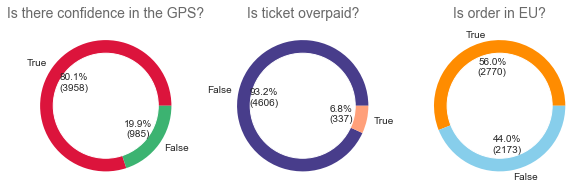

In [15]:
## Plot Boolean Columns
fig, axs = plt.subplots(1, 3, figsize=(10, 10))
viz_utils.donut_plot(df, col='is_gps_confident', colors=['crimson', 'mediumseagreen'], ax=axs[0], 
           title='Is there confidence in the GPS?')
viz_utils.donut_plot(df, col='is_overpaid_ride_ticket', colors=['darkslateblue', 'lightsalmon'], ax=axs[1], 
           title='Is ticket overpaid?')
viz_utils.donut_plot(df, col='is_eu', colors=['darkorange', 'skyblue'], ax=axs[2], 
           title='Is order in EU?')

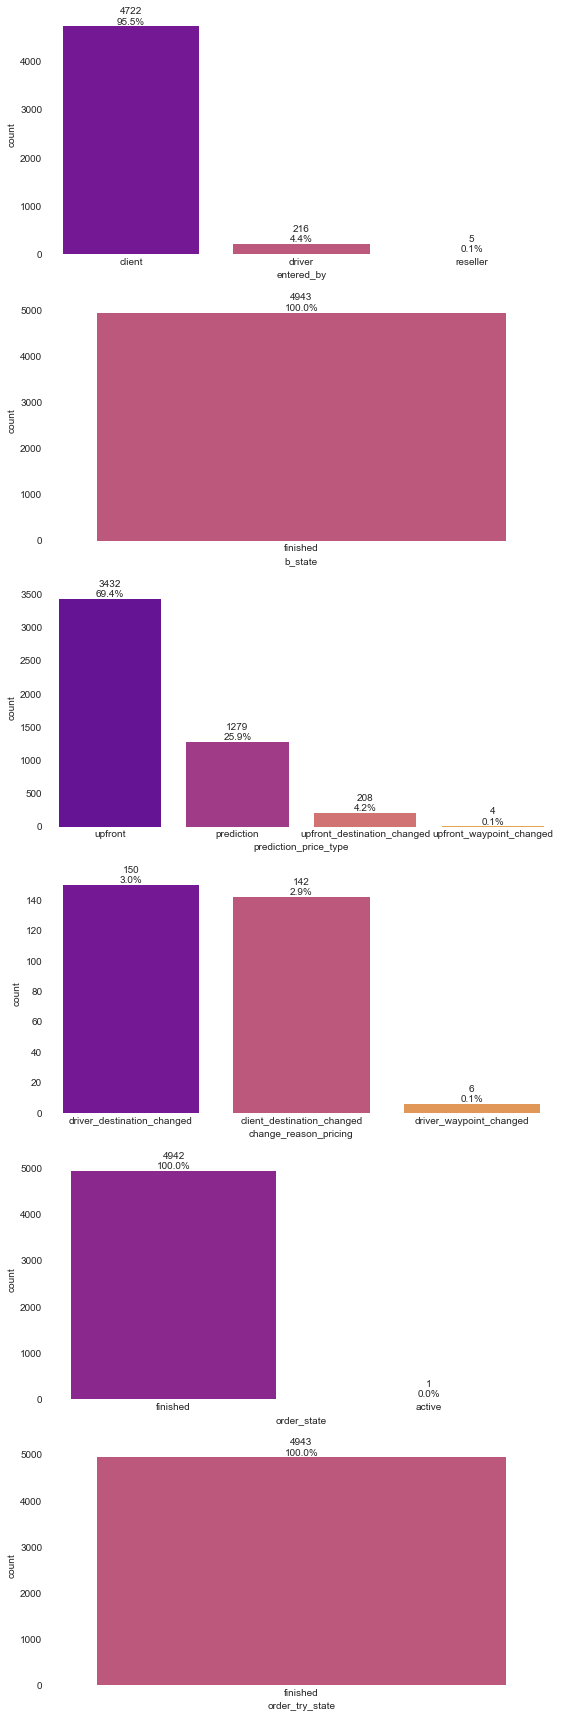

In [16]:
# Filter object columns which have less than 10 unique values
filtered_cols = [col for col in categorical_columns if df[col].nunique() < 15 and col not in df.filter(regex='^is', axis=1).columns]

# Create a figure which will contain subplots
fig, axs = plt.subplots(len(filtered_cols), figsize=(8, 24))

# Check if there's only one plot, if so convert axs to list
if not isinstance(axs, np.ndarray):
    axs = np.array([axs])

# Loop over all filtered columns
for col, ax in zip(filtered_cols, axs):
    viz_utils.single_countplot(df, x=col, ax=ax)

plt.tight_layout()
plt.show()


In [17]:
diff_orderid_rows = df[df['order_id_new'] != df['order_try_id_new']]
diff_orderid_rows.head()


,order_id_new,order_try_id_new,metered_price,upfront_price,distance,duration,is_gps_confident,entered_by,b_state,dest_change_number,prediction_price_type,predicted_distance,predicted_duration,change_reason_pricing,ticket_id_new,device_token,rider_app_version,order_state,order_try_state,driver_app_version,driver_device_uid_new,device_name,is_eu,is_overpaid_ride_ticket,fraud_score,date,date_year,date_month,date_month_name,date_year_month,date_day,date_dayofweek,date_dayofweek_name,date_time_day
52,1608,1609,4087.50,4500.0,4752,1755,True,client,finished,2,upfront,6791.0,1179.0,client_destination_changed,3171,NaN,CA.5.44,finished,finished,DA.4.37,2076,TECNO WX3,False,False,NaN,2020-02-17 08:45:21,2020,2,Feb,202002,17,0,Mon,Morning
67,536,537,11323.02,8500.0,8573,1168,False,client,finished,1,upfront,5398.0,1049.0,NaN,1963,NaN,CA.5.27,finished,finished,DA.4.10,253,TECNO MOBILE LIMITED TECNO B1,False,True,NaN,2020-02-07 15:12:43,2020,2,Feb,202002,7,4,Fri,Afternoon
93,1716,1715,2.54,3.3,2193,352,True,client,finished,1,upfront,3586.0,406.0,NaN,3304,NaN,CA.5.44,finished,finished,DA.4.39,427,Samsung SM-G532F,True,False,-246.0,2020-02-18 13:07:14,2020,2,Feb,202002,18,1,Tue,Afternoon
318,2024,2023,16337.46,NaN,8688,3827,True,client,finished,1,prediction,5509.0,1156.0,NaN,3684,NaN,CA.5.32,finished,finished,DA.4.39,310,Samsung SAMSUNG-SM-G900A,False,True,NaN,2020-02-21 15:48:59,2020,2,Feb,202002,21,4,Fri,Afternoon
332,1255,1254,2.92,3.0,2407,366,True,client,finished,1,upfront,2376.0,386.0,NaN,3030,NaN,CI.4.17,finished,finished,DA.4.37,885,Samsung SM-J700H,True,False,-90.0,2020-02-14 13:40:31,2020,2,Feb,202002,14,4,Fri,Afternoon


In [18]:
df[(df['order_id_new'] == 4154)]

,order_id_new,order_try_id_new,metered_price,upfront_price,distance,duration,is_gps_confident,entered_by,b_state,dest_change_number,prediction_price_type,predicted_distance,predicted_duration,change_reason_pricing,ticket_id_new,device_token,rider_app_version,order_state,order_try_state,driver_app_version,driver_device_uid_new,device_name,is_eu,is_overpaid_ride_ticket,fraud_score,date,date_year,date_month,date_month_name,date_year_month,date_day,date_dayofweek,date_dayofweek_name,date_time_day
4256,4154,4154,2.6,3.7,2329,357,True,client,finished,1,upfront,4014.0,504.0,NaN,1283,NaN,CA.5.47,finished,finished,DA.4.31,1252,Xiaomi Redmi 6A,True,False,NaN,2020-03-13 22:08:42,2020,3,Mar,202003,13,4,Fri,Night
4571,4154,4154,2.6,3.7,2329,357,True,client,finished,1,upfront,4014.0,504.0,NaN,1284,NaN,CA.5.47,finished,finished,DA.4.31,1252,Xiaomi Redmi 6A,True,False,NaN,2020-03-13 22:08:42,2020,3,Mar,202003,13,4,Fri,Night


In [19]:
# Check for duplicate rows
duplicate_rows_df = df[df.duplicated()]

duplicate_rows_df


,order_id_new,order_try_id_new,metered_price,upfront_price,distance,duration,is_gps_confident,entered_by,b_state,dest_change_number,prediction_price_type,predicted_distance,predicted_duration,change_reason_pricing,ticket_id_new,device_token,rider_app_version,order_state,order_try_state,driver_app_version,driver_device_uid_new,device_name,is_eu,is_overpaid_ride_ticket,fraud_score,date,date_year,date_month,date_month_name,date_year_month,date_day,date_dayofweek,date_dayofweek_name,date_time_day


Seems like duplicated order_id_new and order_try_id_new is due to ticket id and we are not interested in that field.

In [20]:

duplicate_rows_df = df[df.duplicated(subset=['order_id_new','order_try_id_new'], keep=False)]
duplicate_rows_df = duplicate_rows_df.sort_values(['order_id_new','order_try_id_new'], ascending=False)
duplicate_rows_df

,order_id_new,order_try_id_new,metered_price,upfront_price,distance,duration,is_gps_confident,entered_by,b_state,dest_change_number,prediction_price_type,predicted_distance,predicted_duration,change_reason_pricing,ticket_id_new,device_token,rider_app_version,order_state,order_try_state,driver_app_version,driver_device_uid_new,device_name,is_eu,is_overpaid_ride_ticket,fraud_score,date,date_year,date_month,date_month_name,date_year_month,date_day,date_dayofweek,date_dayofweek_name,date_time_day
1669,4155,4155,12910.02,NaN,10369,1133,True,client,finished,1,prediction,11873.0,1633.0,NaN,1245,NaN,CA.5.46,finished,finished,DA.4.42,2111,Samsung SM-N9100,False,False,NaN,2020-03-13 22:23:41,2020,3,Mar,202003,13,4,Fri,Night
2872,4155,4155,12910.02,NaN,10369,1133,True,client,finished,1,prediction,11873.0,1633.0,NaN,1270,NaN,CA.5.46,finished,finished,DA.4.42,2111,Samsung SM-N9100,False,False,NaN,2020-03-13 22:23:41,2020,3,Mar,202003,13,4,Fri,Night
4256,4154,4154,2.60,3.7,2329,357,True,client,finished,1,upfront,4014.0,504.0,NaN,1283,NaN,CA.5.47,finished,finished,DA.4.31,1252,Xiaomi Redmi 6A,True,False,NaN,2020-03-13 22:08:42,2020,3,Mar,202003,13,4,Fri,Night
4571,4154,4154,2.60,3.7,2329,357,True,client,finished,1,upfront,4014.0,504.0,NaN,1284,NaN,CA.5.47,finished,finished,DA.4.31,1252,Xiaomi Redmi 6A,True,False,NaN,2020-03-13 22:08:42,2020,3,Mar,202003,13,4,Fri,Night
3865,4140,4140,14.10,11.8,21181,1810,True,client,finished,1,upfront,16206.0,1723.0,NaN,1236,NaN,CA.5.47,finished,finished,DA.4.42,551,Xiaomi Redmi 6A,True,False,NaN,2020-03-13 20:11:20,2020,3,Mar,202003,13,4,Fri,Night
4543,4140,4140,14.10,11.8,21181,1810,True,client,finished,1,upfront,16206.0,1723.0,NaN,1261,NaN,CA.5.47,finished,finished,DA.4.42,551,Xiaomi Redmi 6A,True,False,NaN,2020-03-13 20:11:20,2020,3,Mar,202003,13,4,Fri,Night
3885,4136,4136,15848.22,NaN,11639,2112,True,client,finished,1,prediction,12337.0,1967.0,NaN,1229,NaN,CI.4.19,finished,finished,DA.4.42,359,Samsung SM-G950U,False,False,NaN,2020-03-13 19:23:44,2020,3,Mar,202003,13,4,Fri,Night
4627,4136,4136,15848.22,NaN,11639,2112,True,client,finished,1,prediction,12337.0,1967.0,NaN,1228,NaN,CI.4.19,finished,finished,DA.4.42,359,Samsung SM-G950U,False,False,NaN,2020-03-13 19:23:44,2020,3,Mar,202003,13,4,Fri,Night
3411,4127,4127,15389.46,NaN,9908,2711,True,client,finished,1,prediction,8991.0,1799.0,NaN,1213,NaN,CI.4.00,finished,finished,DA.4.42,1840,Samsung SM-G950F,False,False,NaN,2020-03-13 17:14:49,2020,3,Mar,202003,13,4,Fri,Afternoon
3602,4127,4127,15389.46,NaN,9908,2711,True,client,finished,1,prediction,8991.0,1799.0,NaN,1247,NaN,CI.4.00,finished,finished,DA.4.42,1840,Samsung SM-G950F,False,False,NaN,2020-03-13 17:14:49,2020,3,Mar,202003,13,4,Fri,Afternoon


In [21]:
df = df.drop_duplicates(subset=['order_id_new', 'order_try_id_new'], keep='first')
df.shape

(4166, 34)

In [22]:
all_same = (df['order_id_new'] == df['order_try_id_new']).all()

print(all_same)


False


In [23]:
df_different = df[df['order_id_new'] != df['order_try_id_new']].sort_values('order_id_new', ascending=False)
df_different.tail()

,order_id_new,order_try_id_new,metered_price,upfront_price,distance,duration,is_gps_confident,entered_by,b_state,dest_change_number,prediction_price_type,predicted_distance,predicted_duration,change_reason_pricing,ticket_id_new,device_token,rider_app_version,order_state,order_try_state,driver_app_version,driver_device_uid_new,device_name,is_eu,is_overpaid_ride_ticket,fraud_score,date,date_year,date_month,date_month_name,date_year_month,date_day,date_dayofweek,date_dayofweek_name,date_time_day
4240,404,406,40697.00,26500.0,23779,6354,True,client,finished,2,upfront,18733.0,3128.0,client_destination_changed,1831,NaN,CA.5.43,finished,finished,DA.4.37,2129,INFINIX MOBILITY LIMITED Infinix X5516B,False,False,NaN,2020-02-06 08:02:05,2020,2,Feb,202002,6,3,Thu,Morning
3692,403,402,11.50,9.4,10326,1823,True,client,finished,1,upfront,9785.0,1199.0,NaN,1819,NaN,CA.5.23,finished,finished,DA.4.37,469,Samsung SM-G920F,True,False,NaN,2020-02-06 06:20:08,2020,2,Feb,202002,6,3,Thu,Dawn
638,402,403,7894.13,9000.0,4266,1000,True,client,finished,1,upfront,5439.0,1086.0,NaN,1918,NaN,CA.5.42,finished,finished,DA.4.30,514,TECNO MOBILE LIMITED TECNO LC6,False,False,NaN,2020-02-06 06:22:57,2020,2,Feb,202002,6,3,Thu,Dawn
338,150,149,20726.77,25000.0,14339,2420,False,client,finished,1,upfront,17293.0,2203.0,NaN,1522,NaN,CA.5.19,finished,finished,DA.4.37,820,TECNO MOBILE LIMITED TECNO B1,False,False,NaN,2020-02-03 12:17:59,2020,2,Feb,202002,3,0,Mon,Morning
742,149,150,17752.64,22500.0,13300,1875,True,client,finished,1,upfront,17393.0,1466.0,NaN,1512,NaN,CA.5.42,finished,finished,DA.4.37,1986,HUAWEI TRT-L21A,False,False,NaN,2020-02-03 11:18:58,2020,2,Feb,202002,3,0,Mon,Morning


In [24]:
df = df.drop(columns=['b_state', 'order_state', 'order_try_state', 'ticket_id_new','driver_device_uid_new','device_token'])
df.head()

,order_id_new,order_try_id_new,metered_price,upfront_price,distance,duration,is_gps_confident,entered_by,dest_change_number,prediction_price_type,predicted_distance,predicted_duration,change_reason_pricing,rider_app_version,driver_app_version,device_name,is_eu,is_overpaid_ride_ticket,fraud_score,date,date_year,date_month,date_month_name,date_year_month,date_day,date_dayofweek,date_dayofweek_name,date_time_day
0,22,22,4.04,10.0,2839,700,True,client,1,upfront,13384.0,1091.0,NaN,CI.4.17,DA.4.37,Xiaomi Redmi 6,True,False,-1383.0,2020-02-02 03:37:31,2020,2,Feb,202002,2,6,Sun,Dawn
1,618,618,6.09,3.6,5698,493,True,client,1,upfront,2286.0,360.0,NaN,CA.5.43,DA.4.39,Samsung SM-G965F,True,False,NaN,2020-02-08 02:26:19,2020,2,Feb,202002,8,5,Sat,Dawn
2,657,657,4.32,3.5,4426,695,True,client,1,upfront,4101.0,433.0,NaN,CA.5.43,DA.4.37,Samsung SM-A530F,True,False,-166.0,2020-02-08 11:50:35,2020,2,Feb,202002,8,5,Sat,Morning
3,313,313,72871.72,NaN,49748,1400,False,client,2,upfront_destination_changed,3017.0,600.0,client_destination_changed,CA.5.23,DA.4.37,TECNO-Y6,False,True,NaN,2020-02-05 06:34:54,2020,2,Feb,202002,5,2,Wed,Dawn
4,1176,1176,20032.50,19500.0,10273,5067,True,client,1,upfront,14236.0,2778.0,NaN,CA.5.04,DA.4.37,Itel W5504,False,False,NaN,2020-02-13 17:31:24,2020,2,Feb,202002,13,3,Thu,Afternoon


In [25]:
from IPython.display import Markdown, display


markdown_table = "| Column Name | Sample of Unique Values |\n| --- | --- |\n"

for col in df.columns:
    unique_values_sample = df[col].dropna().unique()[:10]  # Get a sample of 10 unique values
    markdown_table += f"| **{col}** | {', '.join(str(val) for val in unique_values_sample)} |\n"

display(Markdown(markdown_table))

| Column Name | Sample of Unique Values |
| --- | --- |
| **order_id_new** | 22, 618, 657, 313, 1176, 1209, 761, 1662, 1904, 1999 |
| **order_try_id_new** | 22, 618, 657, 313, 1176, 1209, 761, 1662, 1904, 1999 |
| **metered_price** | 4.04, 6.09, 4.32, 72871.72, 20032.5, 6.11, 20753.2, 2.61, 13600.5, 4.14 |
| **upfront_price** | 10.0, 3.6, 3.5, 19500.0, 6.3, 10500.0, 6.5, 2.5, 8.1, 8.7 |
| **distance** | 2839, 5698, 4426, 49748, 10273, 4924, 10459, 2020, 9540, 3845 |
| **duration** | 700, 493, 695, 1400, 5067, 513, 1874, 412, 1917, 720 |
| **is_gps_confident** | True, False |
| **entered_by** | client, driver, reseller |
| **dest_change_number** | 1, 2, 3, 4, 5, 6, 7, 9, 12 |
| **prediction_price_type** | upfront, upfront_destination_changed, prediction, upfront_waypoint_changed |
| **predicted_distance** | 13384.0, 2286.0, 4101.0, 3017.0, 14236.0, 4882.0, 4892.0, 8545.0, 11018.0, 1883.0 |
| **predicted_duration** | 1091.0, 360.0, 433.0, 600.0, 2778.0, 562.0, 698.0, 888.0, 1914.0, 298.0 |
| **change_reason_pricing** | client_destination_changed, driver_destination_changed, driver_waypoint_changed |
| **rider_app_version** | CI.4.17, CA.5.43, CA.5.23, CA.5.04, CI.4.18, CA.5.40, CA.5.44, CI.4.19, CA.5.32, CA.5.46 |
| **driver_app_version** | DA.4.37, DA.4.39, DA.4.19, DA.4.31, DI.3.37, DA.4.42, DA.4.10, DA.4.34, DI.3.31, DI.3.33 |
| **device_name** | Xiaomi Redmi 6, Samsung SM-G965F, Samsung SM-A530F, TECNO-Y6, Itel W5504, HUAWEI WAS-LX1, TECNO MOBILE LIMITED TECNO KA7O, Samsung SM-N950F, TECNO K7, Samsung SM-G930F |
| **is_eu** | True, False |
| **is_overpaid_ride_ticket** | False, True |
| **fraud_score** | -1383.0, -166.0, -2350.0, -5181.0, -652.0, -100.0, -58.0, -44.0, -498.0, -160.0 |
| **date** | 2020-02-02 03:37:31, 2020-02-08 02:26:19, 2020-02-08 11:50:35, 2020-02-05 06:34:54, 2020-02-13 17:31:24, 2020-02-14 01:27:01, 2020-02-09 06:51:20, 2020-02-17 18:24:45, 2020-02-20 16:38:34, 2020-02-21 11:02:38 |
| **date_year** | 2020 |
| **date_month** | 2, 3 |
| **date_month_name** | Feb, Mar |
| **date_year_month** | 202002, 202003 |
| **date_day** | 2, 8, 5, 13, 14, 9, 17, 20, 21, 24 |
| **date_dayofweek** | 6, 5, 2, 3, 4, 0, 1 |
| **date_dayofweek_name** | Sun, Sat, Wed, Thu, Fri, Mon, Tue |
| **date_time_day** | Dawn, Morning, Afternoon, Night |


In [26]:
df['percentage_price_error'] = ((df['metered_price'] - df['upfront_price']).abs() / df['upfront_price']) * 100
# create a variable price_difference_category
df['price_difference_category'] = df['percentage_price_error'].apply(lambda x: 'a_lot' if x > 0.2 else 'little_or_no_switching')


In [27]:
def calculate_price_paid(row):
    if row['price_difference_category'] == 'a_lot':
        return row['metered_price']
    else:
        return row['upfront_price']

df['price_paid'] = df.apply(calculate_price_paid, axis=1)

In [28]:
df.head()

,order_id_new,order_try_id_new,metered_price,upfront_price,distance,duration,is_gps_confident,entered_by,dest_change_number,prediction_price_type,predicted_distance,predicted_duration,change_reason_pricing,rider_app_version,driver_app_version,device_name,is_eu,is_overpaid_ride_ticket,fraud_score,date,date_year,date_month,date_month_name,date_year_month,date_day,date_dayofweek,date_dayofweek_name,date_time_day,percentage_price_error,price_difference_category,price_paid
0,22,22,4.04,10.0,2839,700,True,client,1,upfront,13384.0,1091.0,NaN,CI.4.17,DA.4.37,Xiaomi Redmi 6,True,False,-1383.0,2020-02-02 03:37:31,2020,2,Feb,202002,2,6,Sun,Dawn,59.600000,a_lot,4.04
1,618,618,6.09,3.6,5698,493,True,client,1,upfront,2286.0,360.0,NaN,CA.5.43,DA.4.39,Samsung SM-G965F,True,False,NaN,2020-02-08 02:26:19,2020,2,Feb,202002,8,5,Sat,Dawn,69.166667,a_lot,6.09
2,657,657,4.32,3.5,4426,695,True,client,1,upfront,4101.0,433.0,NaN,CA.5.43,DA.4.37,Samsung SM-A530F,True,False,-166.0,2020-02-08 11:50:35,2020,2,Feb,202002,8,5,Sat,Morning,23.428571,a_lot,4.32
3,313,313,72871.72,NaN,49748,1400,False,client,2,upfront_destination_changed,3017.0,600.0,client_destination_changed,CA.5.23,DA.4.37,TECNO-Y6,False,True,NaN,2020-02-05 06:34:54,2020,2,Feb,202002,5,2,Wed,Dawn,NaN,little_or_no_switching,NaN
4,1176,1176,20032.50,19500.0,10273,5067,True,client,1,upfront,14236.0,2778.0,NaN,CA.5.04,DA.4.37,Itel W5504,False,False,NaN,2020-02-13 17:31:24,2020,2,Feb,202002,13,3,Thu,Afternoon,2.730769,a_lot,20032.50


In [29]:
df.columns

Index(['order_id_new', 'order_try_id_new', 'metered_price', 'upfront_price',
       'distance', 'duration', 'is_gps_confident', 'entered_by',
       'dest_change_number', 'prediction_price_type', 'predicted_distance',
       'predicted_duration', 'change_reason_pricing', 'rider_app_version',
       'driver_app_version', 'device_name', 'is_eu', 'is_overpaid_ride_ticket',
       'fraud_score', 'date', 'date_year', 'date_month', 'date_month_name',
       'date_year_month', 'date_day', 'date_dayofweek', 'date_dayofweek_name',
       'date_time_day', 'percentage_price_error', 'price_difference_category',
       'price_paid'],
      dtype='object')


Mean price error by is_gps_confident:
is_gps_confident
False    92.527045
True     23.039725
Name: percentage_price_error, dtype: float64


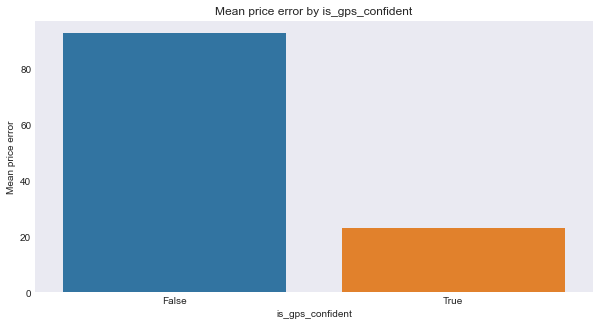


Mean price error by is_eu:
is_eu
False    55.070125
True     22.435896
Name: percentage_price_error, dtype: float64


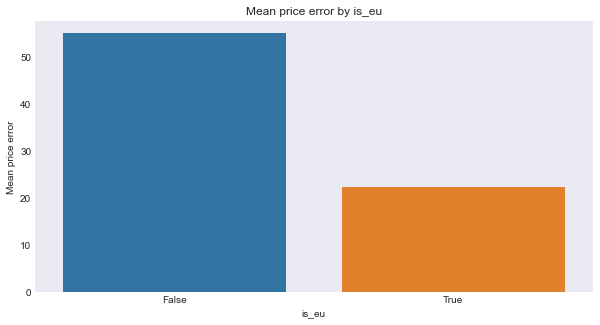


Mean price error by entered_by:
entered_by
client      29.561121
driver      48.730267
reseller          NaN
Name: percentage_price_error, dtype: float64


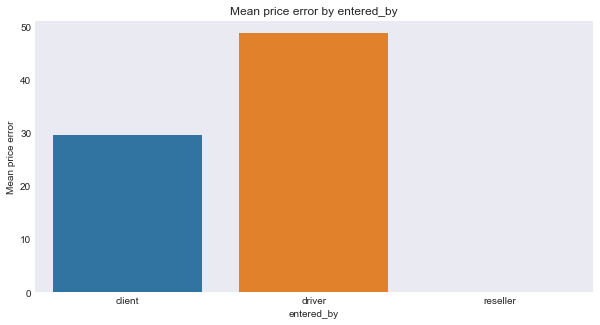


Mean price error by dest_change_number:
dest_change_number
1      28.822835
2      36.863870
3      65.525390
4     156.289365
5       2.893103
6            NaN
7      78.221525
9            NaN
12           NaN
Name: percentage_price_error, dtype: float64


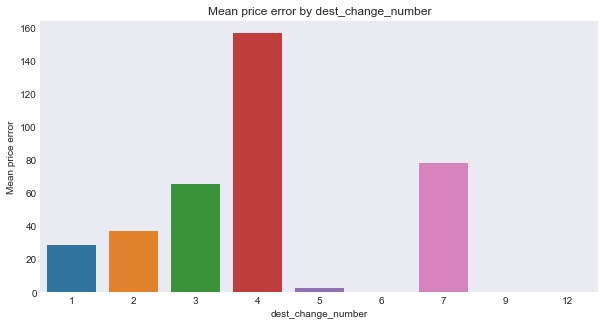


Mean price error by rider_app_version:
rider_app_version
CA.4.27           NaN
CA.4.41      9.315961
CA.4.42           NaN
CA.4.43    105.377750
CA.4.44     73.333333
CA.4.45     22.500000
CA.4.47     21.111111
CA.4.52      5.545714
CA.4.58     97.820327
CA.4.60      9.251250
CA.4.61     14.363000
CA.4.62           NaN
CA.4.63           NaN
CA.4.65           NaN
CA.4.66     62.500000
CA.4.67     45.712857
CA.4.69           NaN
CA.4.71     38.888889
CA.4.72      0.000000
CA.4.73    117.126597
CA.4.75     24.204617
CA.4.77     23.165963
CA.4.79     22.887800
CA.4.81     28.996941
CA.4.82     16.255952
CA.4.83      1.160269
CA.4.86      4.582308
CA.4.87     32.716762
CA.4.89     45.934679
CA.4.91     24.020311
CA.4.92      6.000000
CA.4.93     67.033189
CA.4.95      7.948000
CA.4.97     13.720590
CA.4.99    114.952820
CA.5.00     70.175294
CA.5.01     35.890394
CA.5.02     15.824151
CA.5.04     40.726749
CA.5.07     10.501928
CA.5.08     34.190491
CA.5.13     35.103528
CA.5.16           

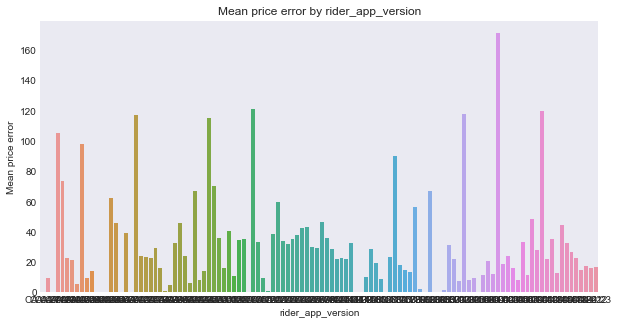


Mean price error by driver_app_version:
driver_app_version
DA.4.10    110.222575
DA.4.12     37.205525
DA.4.14     82.315715
DA.4.16     59.329704
DA.4.19     89.092737
DA.4.22      3.730606
DA.4.23     62.979173
DA.4.29     20.020768
DA.4.30     36.587808
DA.4.31     38.557449
DA.4.32      0.000000
DA.4.33     18.125674
DA.4.34     29.521166
DA.4.35     46.865928
DA.4.37     32.642035
DA.4.38     35.124414
DA.4.39     27.857725
DA.4.41     17.229220
DA.4.42     22.947866
DI.3.21      5.346938
DI.3.26     24.889770
DI.3.28      0.765783
DI.3.29           NaN
DI.3.30     18.452381
DI.3.31     46.507163
DI.3.32     38.526177
DI.3.33     32.005811
DI.3.34     27.754023
DI.3.35     15.875614
DI.3.36     20.319555
DI.3.37     15.864049
DI.3.38     13.750000
DI.3.39     26.764735
Name: percentage_price_error, dtype: float64


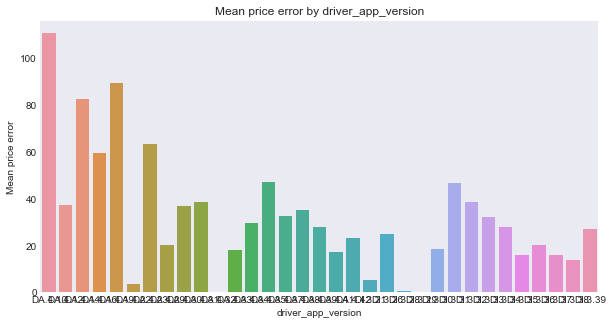


Mean price error by is_overpaid_ride_ticket:
is_overpaid_ride_ticket
False    28.644259
True     73.038935
Name: percentage_price_error, dtype: float64


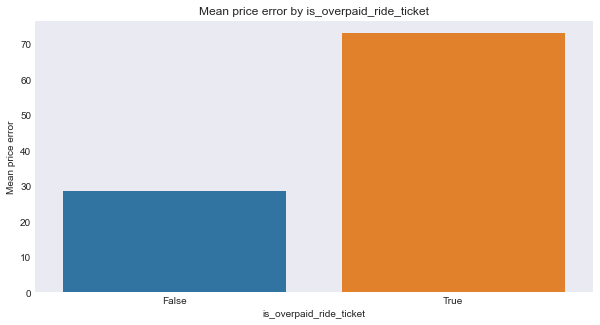


Mean price error by fraud_score:
fraud_score
-14225.0      8.750000
-11400.0      8.987342
-10614.0      3.531915
-10534.0      0.000000
-8794.0     103.750000
-8237.0      22.156863
-8188.0       1.315789
-7766.0      22.500000
-7020.0       8.906250
-6778.0       0.000000
-6522.0      20.526316
-6224.0      41.891892
-6118.0      60.317460
-5805.0       2.222222
-5804.0       1.197183
-5540.0      26.000000
-5512.0      41.397849
-5383.0       4.835165
-5238.0       5.600000
-5228.0     101.904762
-5181.0      65.600000
-5128.0       8.823529
-5052.0       7.500000
-5010.0      16.666667
-4908.0       0.000000
-4876.0       8.378378
-4720.0       5.641026
-4664.0       8.827152
-4568.0            NaN
-4446.0      29.705882
-4430.0      11.969697
-4388.0      53.255814
-4346.0       0.000000
-4270.0      21.250000
-4151.0       3.478261
-4110.0      31.756757
-4040.0      43.181818
-4032.0      45.142857
-4014.0      13.411765
-3922.0       4.074074
-3909.0      34.210526
-3819.0    

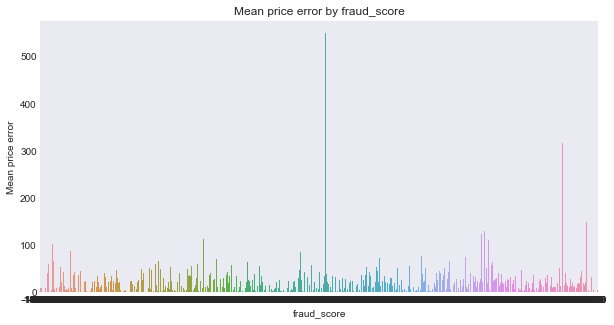


Mean price error by date_time_day:
date_time_day
Dawn         27.262938
Morning      30.596661
Afternoon    31.907750
Night        28.540015
Name: percentage_price_error, dtype: float64


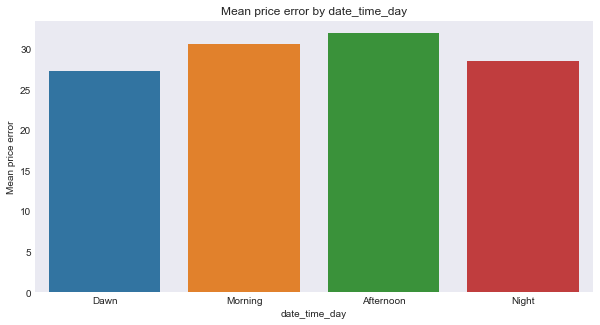

In [30]:

# List of columns to investigate
columns_to_investigate = ['is_gps_confident','is_eu', 'entered_by', 'dest_change_number', 'rider_app_version', 'driver_app_version', 'is_overpaid_ride_ticket', 'fraud_score', 'date_time_day']

# Iterate over columns to investigate
for column in columns_to_investigate:
    # Calculate mean price error for each category in the column
    mean_price_error = df.groupby(column)['percentage_price_error'].mean()
    
    # Print the results
    print(f"\nMean price error by {column}:\n{mean_price_error}")
    
    # Create a bar plot of the results
    plt.figure(figsize=(10,5))
    sns.barplot(x=mean_price_error.index, y=mean_price_error.values)
    plt.title(f"Mean price error by {column}")
    plt.ylabel("Mean price error")
    plt.show()


In [31]:
df.columns

Index(['order_id_new', 'order_try_id_new', 'metered_price', 'upfront_price',
       'distance', 'duration', 'is_gps_confident', 'entered_by',
       'dest_change_number', 'prediction_price_type', 'predicted_distance',
       'predicted_duration', 'change_reason_pricing', 'rider_app_version',
       'driver_app_version', 'device_name', 'is_eu', 'is_overpaid_ride_ticket',
       'fraud_score', 'date', 'date_year', 'date_month', 'date_month_name',
       'date_year_month', 'date_day', 'date_dayofweek', 'date_dayofweek_name',
       'date_time_day', 'percentage_price_error', 'price_difference_category',
       'price_paid'],
      dtype='object')

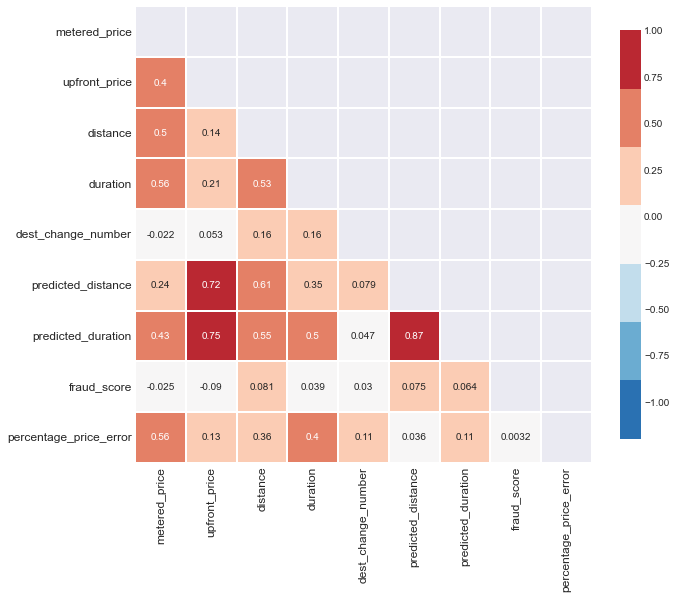

In [32]:
# Only numerical columns
numerical_cols = ['metered_price', 'upfront_price', 'distance', 'duration', 'dest_change_number',
                  'predicted_distance', 'predicted_duration', 'fraud_score', 'percentage_price_error']

rship = df[numerical_cols]

# plot heatmap
mask = np.zeros_like(rship.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(10, 12))
sns.heatmap(rship.corr(),
            mask = mask,
            square=True,
            vmin = -1.2,
            vmax = 1,
            linewidth=0.1,
            cbar_kws = {'shrink':0.5},
            cmap=sns.color_palette("RdBu_r", 7), annot=True)
ax.tick_params(labelsize=12)
plt.tight_layout()



                         percentage_price_error
percentage_price_error                 1.000000
metered_price                          0.558330
price_paid                             0.558330
duration                               0.401640
is_gps_confident                       0.369126
distance                               0.355953
is_eu                                  0.244180
is_overpaid_ride_ticket                0.130221
upfront_price                          0.128726
order_id_new                           0.115858


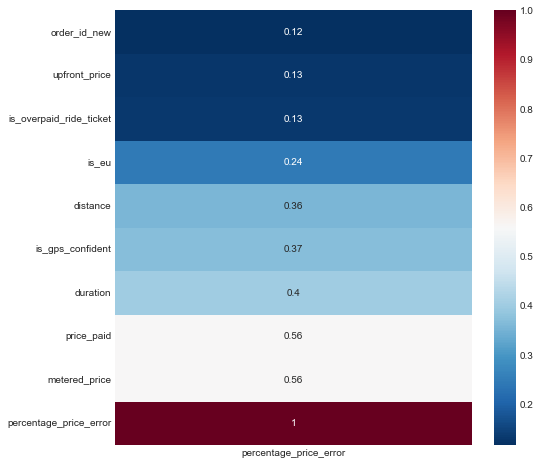

In [33]:
# Select only numeric data
df_numeric = df._get_numeric_data()

# Calculate absolute correlation with 'percentage_price_error'
correlation = np.abs(df_numeric.corr()[['percentage_price_error']])

# Sort and get top 10
top_10_corr = correlation.sort_values('percentage_price_error', ascending=False).head(10)

print(top_10_corr)

# Heatmap of the top 10 correlation values with 'percentage_price_error'
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(top_10_corr, cmap='RdBu_r', annot=True, ax=ax)
ax.invert_yaxis()



In [34]:
pip install -U scikit-learn


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [35]:
# Define columns where NaN values are allowed
cols_nan_allowed = ['change_reason_pricing', 'fraud_score']

# Get all other column names where NaN values are not allowed
cols_nan_not_allowed = df.columns.difference(cols_nan_allowed)

# Drop rows with NaN values in columns where it is not allowed
df = df.dropna(subset=cols_nan_not_allowed)

# Print the number of missing values in each column
print(df.isnull().sum())


order_id_new                    0
order_try_id_new                0
metered_price                   0
upfront_price                   0
distance                        0
duration                        0
is_gps_confident                0
entered_by                      0
dest_change_number              0
prediction_price_type           0
predicted_distance              0
predicted_duration              0
change_reason_pricing        2918
rider_app_version               0
driver_app_version              0
device_name                     0
is_eu                           0
is_overpaid_ride_ticket         0
fraud_score                  1198
date                            0
date_year                       0
date_month                      0
date_month_name                 0
date_year_month                 0
date_day                        0
date_dayofweek                  0
date_dayofweek_name             0
date_time_day                   0
percentage_price_error          0
price_differen

In [41]:
# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor

# Dictionary of models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

# Initialize variables
best_model = None
best_rmse = float('inf')

# Loop through models
for model_name, model in models.items():
    # Append classifier to preprocessing pipeline
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])

    # Train the model
    clf.fit(X_train, y_train)

    # Make predictions
    y_pred = clf.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    # Update best model if current model is better
    if rmse < best_rmse:
        best_model = model_name
        best_rmse = rmse

    print(f'{model_name}\nMean Squared Error: {mse}\nRoot Mean Squared Error: {rmse}\n')

print(f'Best model: {best_model}\nBest RMSE: {best_rmse}')


NameError: name 'X_train' is not defined